# Classification binaire with PyTorch :

https://www.learnpytorch.io/02_pytorch_classification/

## 1 - Make data :

In [ ]:
import sklearn
from sklearn.datasets import make_circles

n_samples= 1000
X,y = make_circles(n_samples, noise=0.03, random_state=42)

print(f'First 5 samples of X:\n{X[:5]}')
print(f'First 5 samples of y:\n{y[:5]}')

First 5 samples of X:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
[1 1 1 1 0]


In [ ]:
## Turn data into tensor :
import torch

X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)

## Split train/test :
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=0.2, ## 80% train / 20% test
                                                 random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### 1.2 - Visualisation :

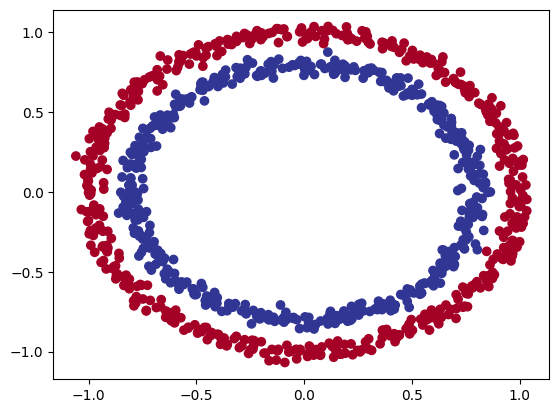

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],y=X[:,1],c=y,cmap=plt.cm.RdYlBu)

## 2 - Build a model :
* Construct model (nn.Module) :

  1- Subclass nn.Module

  2- Create the layers capable of handling the shapes of our data  

  3- Defines a forward() method

  4- Instantiate an instance of our model class and send it to the target device

* Loss function & optimizer
* Training & testing loop
* Make predictions and evaluate the model

### Device agnostic code :

In [ ]:
import torch
from torch import nn

## Setup the device agnostic code
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Create model :

In [ ]:
class CircleModelV0 (nn.Module) : ## 1 - Subclass nn.Module
  def __init__(self) :
    super().__init__()
    ## 2- Create 2 layer of nn.Linear capable of handling the shape of our data
    self.layer_1 = nn.Linear(in_features=2,out_features=5) ## Out_features habituellement multiple de 8 => rule of thumb
    self.layer_2 = nn.Linear(in_features=5,out_features=1)
  def forward(self,x): ## 3-forward method
    return self.layer_2(self.layer_1(x))

## 4- Instantiate an instance of model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
## Une autre méthode pour créer un modèle comme le précédent :
model_0 = nn.Sequential(nn.Linear(in_features=2,out_features=5),
                        nn.Linear(in_features=5,out_features=1)
                        ).to(device)
model_0

## Plus simple mais si le réseau de neurone qu'on veut construire est complexe on aura besoin de la synthaxe précédente

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.6470, -0.6332],
                      [ 0.2022, -0.2157],
                      [ 0.0204, -0.5609],
                      [-0.0681,  0.6413],
                      [ 0.4716,  0.5643]], device='cuda:0')),
             ('0.bias',
              tensor([-0.0657,  0.0062, -0.2963,  0.3212,  0.2127], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.3524, -0.0896, -0.1630, -0.0092,  0.4062]], device='cuda:0')),
             ('1.bias', tensor([0.3263], device='cuda:0'))])

### Set a loss and optimizer


In [ ]:
loss_fn=nn.BCEWithLogitsLoss() ## BCE avec la fonction d'activation sigmoide intégrée (plus stable que BCELoss + sigmoide à part)
                               ## BCELoss() : requires the input to have gone through the sigmoid activation prior to BCELoss

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
## Calculate accuracy - Pourcentage de reussite du modèle

def accuracy_fn(y_true,y_pred):
  correct=torch.eq(y_true,y_pred).sum().item()
  acc=correct/len(y_pred)*100
  return acc

### Training & Testing loop :

Training loop :
* Forward propagation
* Loss
* Zero grad optimizer
* Loss backward
* Optimizer step

Testing loop :
* Forward propagation
* Loss
* Print

In [ ]:
"""
Going from raw logits -> predictions probabilities -> predictions labels
 -> Our outputs are going to be logits; we convert these into predictions probabilities by passing them to some kind of activation function (sigmoid for binary, softmax for multiclass)
 -> We get the labels by rounding the probabilities or by taking the argmax()
"""
## Look at the first 5 outputs of the forward pass :
with torch.inference_mode() :
  y_logits=model_0(X_test.to(device))[:5]
print(y_logits)

## Use the sigmoid activation function on our model's logits :
y_preds_probs=torch.sigmoid(y_logits)
print(y_preds_probs)

## Getting the labels :
print(torch.round(y_preds_probs))

##y_preds_labels=torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

tensor([[0.3605],
        [0.5470],
        [0.1192],
        [0.4278],
        [0.5124]], device='cuda:0')
tensor([[0.5892],
        [0.6334],
        [0.5298],
        [0.6053],
        [0.6254]], device='cuda:0')
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')


In [ ]:
## Training & Testing loop :

torch.manual_seed(42)
torch.cuda.manual_seed(42)

##Set the number of epochs
epochs = 100

##Put data to target device
X_train,y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

## Training and evaluation loop
for epoch in range(epochs) :
  ####Training :
  model_0.train()
  ##1-Forward pass
  y_logits=model_0(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits)) ##logit -> probs -> labels

  ##2-Calculate loss
  loss=loss_fn(y_logits,y_train)
  acc=accuracy_fn(y_true=y_train,y_pred=y_pred)
  ## BCEWithLogitsLoss = inputs en logits; BCELoss = inputs en probs

  ##3-Zero_grad optimizer
  optimizer.zero_grad()

  ##4-Backpropagation
  loss.backward()

  ##5-Gradient descent
  optimizer.step()

  ##Testing
  model_0.eval()
  with torch.inference_mode() :
    ##Forward
    test_logits=model_0(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))

    ##Loss/acc
    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy_fn(y_true=y_test,y_pred=test_pred)

    ##Print
    if epoch%10==0 :
      print(f"'Epoch : {epoch}| Loss: {loss:.5f} | Acc : {acc:.2f}% | Test loss : {test_loss:.5f} | Test acc : {test_acc:.2f}%")

'Epoch : 0| Loss: 0.72305 | Acc : 50.00% | Test loss : 0.73032 | Test acc : 50.50%
'Epoch : 10| Loss: 0.70958 | Acc : 58.75% | Test loss : 0.71567 | Test acc : 54.50%
'Epoch : 20| Loss: 0.70310 | Acc : 53.75% | Test loss : 0.70838 | Test acc : 49.50%
'Epoch : 30| Loss: 0.69974 | Acc : 52.88% | Test loss : 0.70451 | Test acc : 48.50%
'Epoch : 40| Loss: 0.69786 | Acc : 52.25% | Test loss : 0.70229 | Test acc : 49.00%
'Epoch : 50| Loss: 0.69671 | Acc : 51.38% | Test loss : 0.70092 | Test acc : 50.50%
'Epoch : 60| Loss: 0.69595 | Acc : 51.12% | Test loss : 0.70001 | Test acc : 51.00%
'Epoch : 70| Loss: 0.69541 | Acc : 51.25% | Test loss : 0.69937 | Test acc : 49.00%
'Epoch : 80| Loss: 0.69501 | Acc : 51.25% | Test loss : 0.69889 | Test acc : 48.50%
'Epoch : 90| Loss: 0.69470 | Acc : 50.75% | Test loss : 0.69851 | Test acc : 48.50%


### Make predictions and evaluate the model

In [98]:
## On importe des fonctions d'aide depuis un repository GitHub

import requests
from pathlib import Path

if Path("helper_functions.py").is_file() :
  print("help_functions.py already exists, skipping dowload")
else :
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f :
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


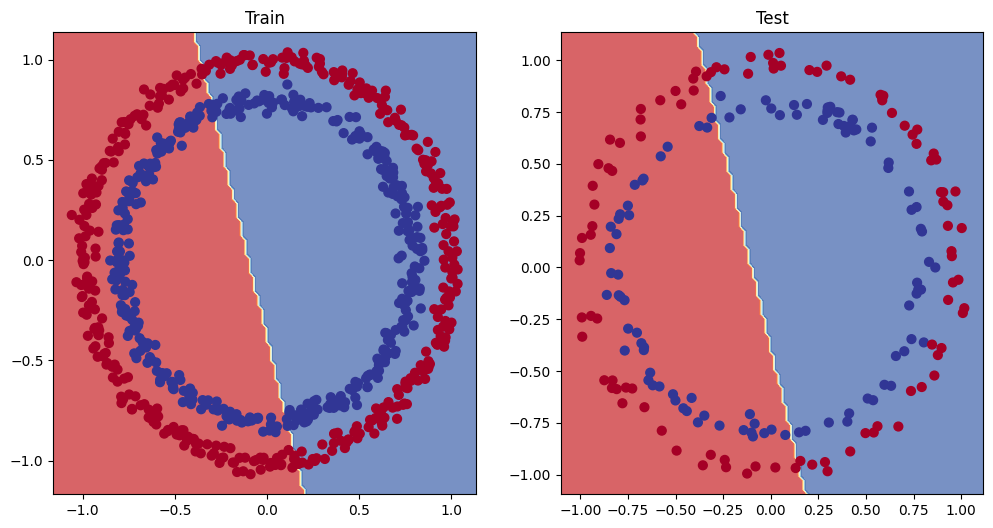

In [ ]:
## Plot decision boundary of the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

## 3 - Improving a model (from a model's perspective) :

* Add more layers (more than 2)
* Add more hidden units (more than 5)
* Fit for longer (more epochs)
* Change the activation function
* Change the learning rate
* Change the loss function

### Create a new model and test it :

In [ ]:
class CircleModelV1(nn.Module) :
  def __init__(self):
    super().__init__()
    ## Usually try to change only one hyperparameter at a time to track the changes
    self.layer1=nn.Linear(in_features=2,out_features=10)
    self.layer2=nn.Linear(in_features=10,out_features=10)
    self.layer3=nn.Linear(in_features=10,out_features=1)
  def forward(self,x):
    return self.layer3(self.layer2(self.layer1(x)))
model_1=CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
## Loss & optimizer
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model_1.parameters(),lr=0.1)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## Training testing loop :
epochs = 1000

##Put data to target device
X_train,y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs) :
  ## Initiate
  model_1.train()
  ## forward
  y_logits=model_1(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))
  ## loss
  loss=loss_fn(y_logits,y_train)
  acc=accuracy_fn(y_true=y_train,y_pred=y_pred)
  ## zero grad
  optimizer.zero_grad()
  ## back prop
  loss.backward()
  ## step
  optimizer.step()

  ##Testing
  model_1.eval() ##Evalation mode
  with torch.inference_mode() :
    ##Forward
    test_logits=model_1(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))

    ##Loss/acc
    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy_fn(y_true=y_test,y_pred=test_pred)

    ##Print
    if epoch%100==0 :
      print(f"Epoch : {epoch}| Loss: {loss:.5f} | Acc : {acc:.2f}% | Test loss : {test_loss:.5f} | Test acc : {test_acc:.2f}%")


Epoch : 0| Loss: 0.69396 | Acc : 50.88% | Test loss : 0.69261 | Test acc : 51.00%
Epoch : 100| Loss: 0.69305 | Acc : 50.38% | Test loss : 0.69379 | Test acc : 48.00%
Epoch : 200| Loss: 0.69299 | Acc : 51.12% | Test loss : 0.69437 | Test acc : 46.00%
Epoch : 300| Loss: 0.69298 | Acc : 51.62% | Test loss : 0.69458 | Test acc : 45.00%
Epoch : 400| Loss: 0.69298 | Acc : 51.12% | Test loss : 0.69465 | Test acc : 46.00%
Epoch : 500| Loss: 0.69298 | Acc : 51.00% | Test loss : 0.69467 | Test acc : 46.00%
Epoch : 600| Loss: 0.69298 | Acc : 51.00% | Test loss : 0.69468 | Test acc : 46.00%
Epoch : 700| Loss: 0.69298 | Acc : 51.00% | Test loss : 0.69468 | Test acc : 46.00%
Epoch : 800| Loss: 0.69298 | Acc : 51.00% | Test loss : 0.69468 | Test acc : 46.00%
Epoch : 900| Loss: 0.69298 | Acc : 51.00% | Test loss : 0.69468 | Test acc : 46.00%


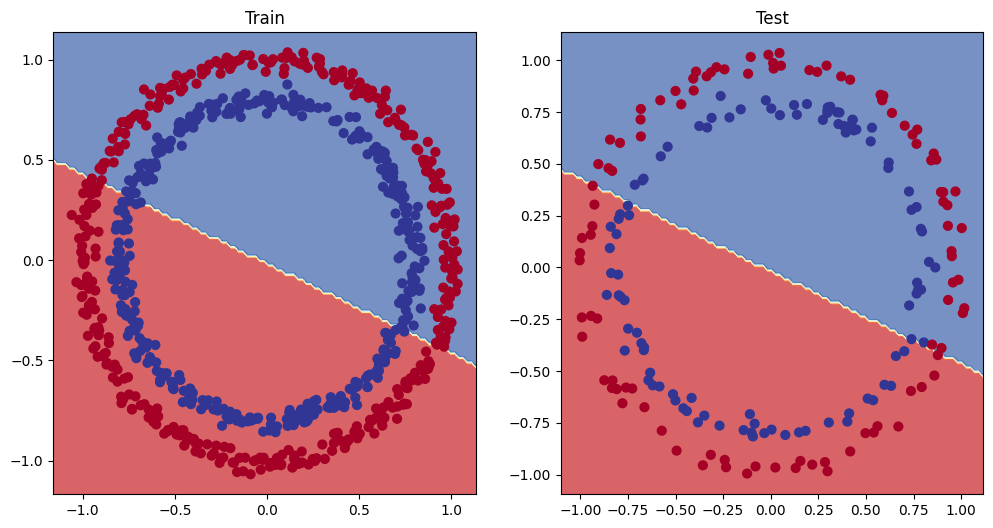

In [ ]:
## Plot decision boundary of the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)

### Prepare data to see if the model can fit straight line :

Test the model on smaller problem to verify if the model can learn something

In [ ]:
##Create data
weight=0.7
bias=0.3
start=0
end=1
step=0.01

X_reg=torch.arange(start,end,step).unsqueeze(dim=1)
y_reg=weight*X_reg+bias

In [ ]:
##Train/test :

train_split=int(0.8*len(X_reg))
X_train_reg,y_train_reg=X_reg[:train_split],y_reg[:train_split]
X_test_reg,y_test_reg=X_reg[train_split:],y_reg[train_split:]

len(X_train_reg),len(X_test_reg),len(y_train_reg),len(y_test_reg)

(80, 20, 80, 20)

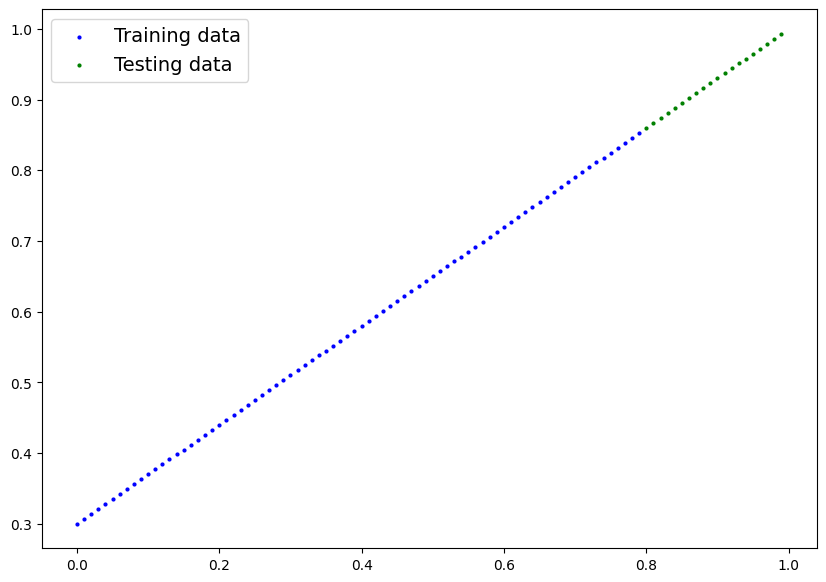

In [ ]:
## Visualize :
plot_predictions(train_data=X_train_reg,
                 train_labels=y_train_reg,
                 test_data=X_test_reg,
                 test_labels=y_test_reg)

#### Adjust model_1 for this type of data :


In [ ]:
model_2=nn.Sequential(nn.Linear(in_features=1,out_features=10),
                      nn.Linear(in_features=10,out_features=10),
                      nn.Linear(in_features=10,out_features=1)).to(device)
model_2

## Loss and optimizer
loss_fn=nn.L1Loss()
optimizer=torch.optim.SGD(params=model_2.parameters(),lr=0.01)

#### Training & Testing Loop :

In [ ]:
##Train :
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=1000

X_train_reg,y_train_reg=X_train_reg.to(device),y_train_reg.to(device)
X_test_reg,y_test_reg=X_test_reg.to(device),y_test_reg.to(device)

##Training loop
for epoch in range(epochs):
  model_2.train()
  y_pred=model_2(X_train_reg)
  loss=loss_fn(y_pred,y_train_reg)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ##testing :
  model_2.eval()
  with torch.inference_mode() :
    test_pred=model_2(X_test_reg)
    test_loss=loss_fn(test_pred,y_test_reg)

    ##Print :
    if epoch%100==0 :
      print(f"Epoch :{epoch} | Loss : {loss:.5f} | Test_Loss : {test_loss:.5f}")

Epoch :0 | Loss : 0.75986 | Test_Loss : 0.91103
Epoch :100 | Loss : 0.02858 | Test_Loss : 0.00081
Epoch :200 | Loss : 0.02533 | Test_Loss : 0.00209
Epoch :300 | Loss : 0.02137 | Test_Loss : 0.00305
Epoch :400 | Loss : 0.01964 | Test_Loss : 0.00341
Epoch :500 | Loss : 0.01940 | Test_Loss : 0.00387
Epoch :600 | Loss : 0.01903 | Test_Loss : 0.00379
Epoch :700 | Loss : 0.01878 | Test_Loss : 0.00381
Epoch :800 | Loss : 0.01840 | Test_Loss : 0.00329
Epoch :900 | Loss : 0.01798 | Test_Loss : 0.00360


#### Evaluate the model :

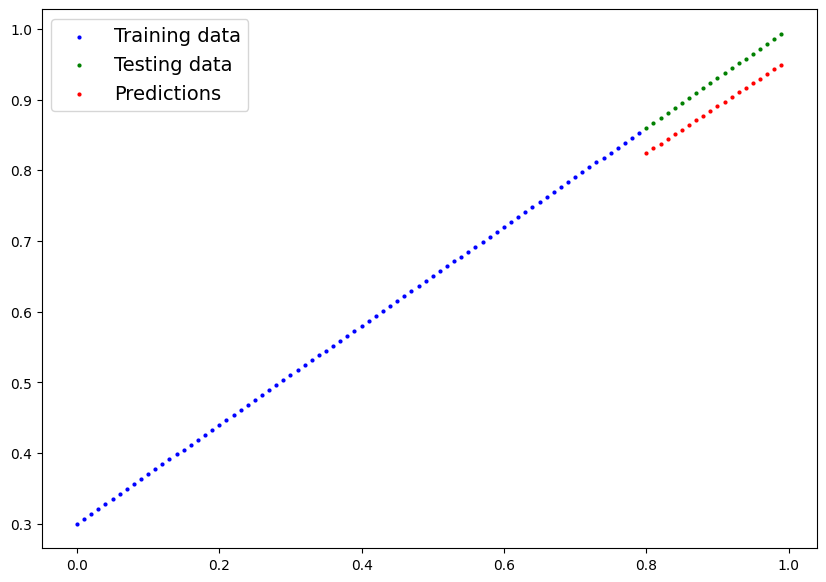

In [ ]:
model_2.eval()

with torch.inference_mode() :
  y_preds=model_2(X_test_reg)

plot_predictions(train_data=X_train_reg.cpu(),
                 train_labels=y_train_reg.cpu(),
                 test_data=X_test_reg.cpu(),
                 test_labels=y_test_reg.cpu(),
                 predictions=y_preds.cpu())

## 4 - Adding non-linearity :

### Make data

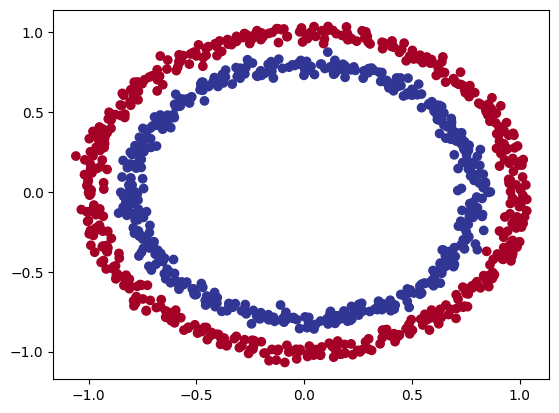

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples,noise=0.03,random_state=42)

plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdYlBu)

In [ ]:
## Convert to Tensor & Train/test split

import torch
from sklearn.model_selection import train_test_split

## Tensor
X1=torch.from_numpy(X).type(torch.float)
y1=torch.from_numpy(y).type(torch.float)

## Split
X_train, X_test,y_train,y_test=train_test_split(X1,y1,test_size=0.2,random_state=42)

X_train[:5], y[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 array([1, 1, 1, 1, 0]))

### Building a model with non-linear activation function

In [ ]:
from torch import nn

class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1=nn.Linear(in_features=2,out_features=10)
    self.layer2=nn.Linear(in_features=10,out_features=10)
    self.layer3=nn.Linear(in_features=10,out_features=1)
    self.relu=nn.ReLU() ## Non-linear activation function

  def forward(self,x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x))))) ## Un ReLU entre chaque couche

model_3=CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
## Loss & optimizer :

loss_fn=nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),lr=0.5)

### Training & Testing loop :

In [ ]:
## Training :

torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

epochs=1000

for epoch in range(epochs):
  model_3.train()
  y_logits=model_3(X_train).squeeze()
  y_preds=torch.round(torch.sigmoid(y_logits))
  loss=loss_fn(y_logits,y_train)
  acc=accuracy_fn(y_true=y_train,y_pred=y_preds)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode() :
    test_logits=model_3(X_test).squeeze()
    test_preds=torch.round(torch.sigmoid(test_logits))

    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy_fn(y_true=y_test,y_pred=test_preds)

    if epoch%100==0 :
      print(f"Epoch : {epoch}| Loss : {loss:.4f} | Acc : {acc:.2f} | Test loss : {test_loss} | Test acc : {test_acc:.2f}")

Epoch : 0| Loss : 0.6929 | Acc : 50.00 | Test loss : 0.6929250955581665 | Test acc : 50.00
Epoch : 100| Loss : 0.6811 | Acc : 52.75 | Test loss : 0.679311990737915 | Test acc : 56.50
Epoch : 200| Loss : 0.5721 | Acc : 86.88 | Test loss : 0.5747385621070862 | Test acc : 86.50
Epoch : 300| Loss : 0.4905 | Acc : 60.12 | Test loss : 0.554294764995575 | Test acc : 60.50
Epoch : 400| Loss : 0.3274 | Acc : 81.38 | Test loss : 0.39383405447006226 | Test acc : 78.50
Epoch : 500| Loss : 0.0389 | Acc : 100.00 | Test loss : 0.06461180746555328 | Test acc : 99.00
Epoch : 600| Loss : 0.0205 | Acc : 100.00 | Test loss : 0.039847247302532196 | Test acc : 99.00
Epoch : 700| Loss : 0.0141 | Acc : 100.00 | Test loss : 0.03126014024019241 | Test acc : 99.50
Epoch : 800| Loss : 0.0108 | Acc : 100.00 | Test loss : 0.02706732228398323 | Test acc : 99.50
Epoch : 900| Loss : 0.0088 | Acc : 100.00 | Test loss : 0.024851100519299507 | Test acc : 99.50


### Evaluate the model :

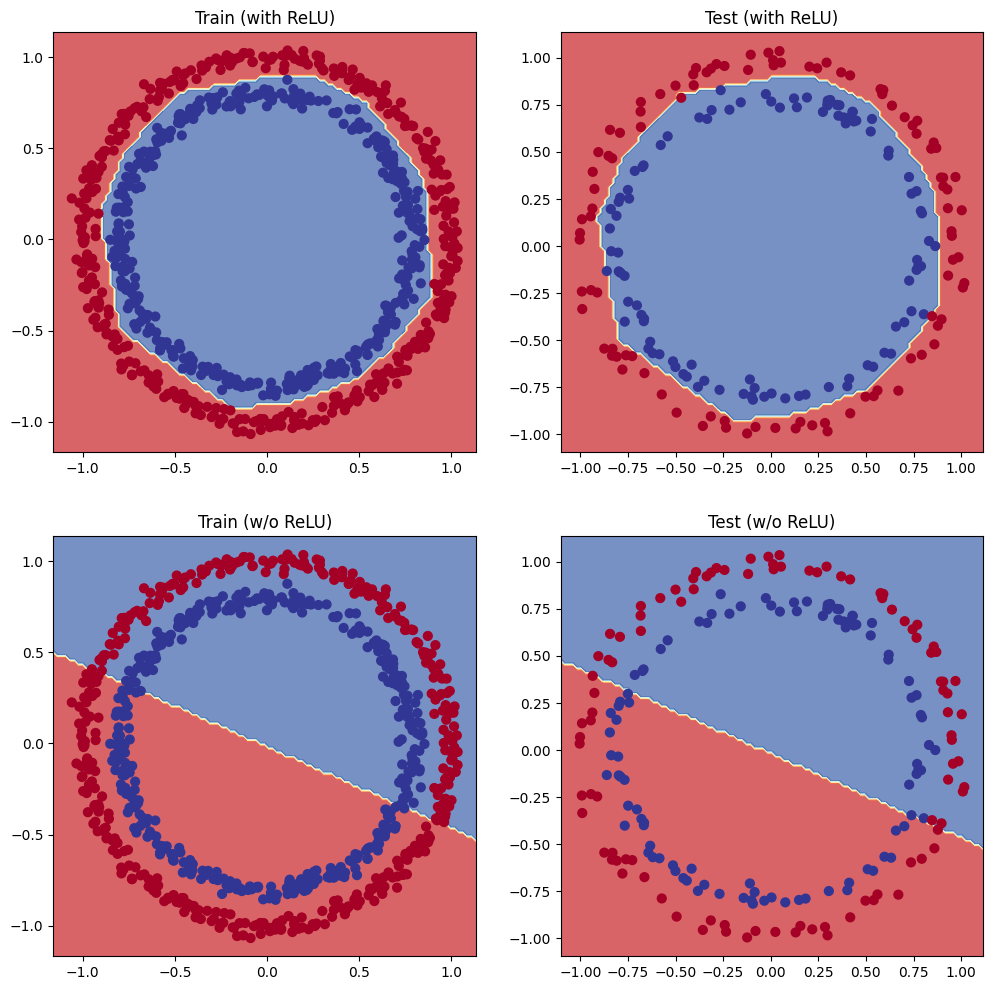

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.title("Train (with ReLU)")
plot_decision_boundary(model_3,X_train,y_train)
plt.subplot(2,2,2)
plt.title("Test (with ReLU)")
plot_decision_boundary(model_3,X_test,y_test)

plt.subplot(2,2,3)
plt.title("Train (w/o ReLU)")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(2,2,4)
plt.title("Test (w/o ReLU)")
plot_decision_boundary(model_1,X_test,y_test)

# Classification multi-classes avec PyTorch :

https://www.learnpytorch.io/02_pytorch_classification/#8-putting-things-together-by-building-a-multi-class-pytorch-model

Pour passer de binaire à multiclasse :
* Sigmoïd devient Softmax
* Binary CrossEntropy devient CrossEntropy

## 1 - Make data :

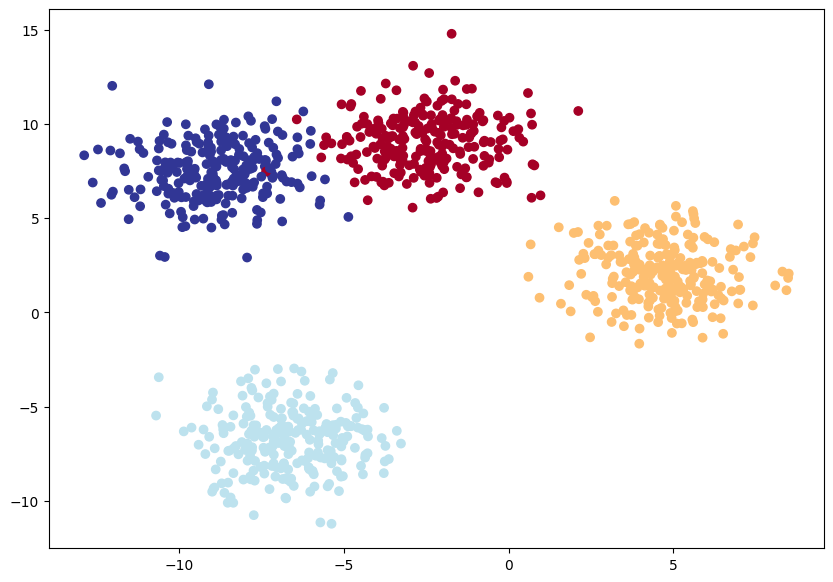

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

##HP for data creation
nb_class=4
nb_features=2
random_seed=42

## Create data :
X_blob,y_blob=make_blobs(n_samples=1000,
                         n_features=nb_features,
                         centers=nb_class,
                         cluster_std=1.5,
                         random_state=random_seed)

## Turn into tensors
X_blobs=torch.from_numpy(X_blob).type(torch.float)
y_blobs=torch.from_numpy(y_blob).type(torch.LongTensor)

## Split
X_blob_train,X_blob_test,y_blob_train,y_blob_test=train_test_split(X_blobs,
                                                                   y_blobs,
                                                                   test_size=0.2,
                                                                   random_state=42)

## Plot :
plt.figure(figsize=(10,7))
plt.scatter(X_blobs[:,0],X_blobs[:,1],c=y_blobs,cmap=plt.cm.RdYlBu)

## 2 - Build a model :

In [ ]:
## Device agnostic code :
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
## Build model :
class BlobModel(nn.Module) :
  def __init__(self,input_features,output_features,hidden_units=8):
    """ Initializes multi_class classification model.

    Args:
      input_features (int) : Number of input features to the model
      output_features (int) : Number of output features (number of class)
      hidden_units (int) : Number of hidden units between layers (default=8)

    Returns :

    Example :
    """
    super().__init__()
    self.linear_layer_stack=nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )
  def forward(self,x):
    return self.linear_layer_stack(x)

## Create an instance :
model_4=BlobModel(input_features=2,output_features=4,hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
## Loss & Optimizer :
loss_fn = nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params =model_4.parameters(),lr=0.1)

## 3 - Training & Testing loop :

In [ ]:
model_4.eval()
with torch.inference_mode() :
  y_logits=model_4(X_blob_test.to(device))

y_logits[:10],y_blob_test[:10]

(tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
         [-0.0973, -0.9431, -0.5963, -0.1371],
         [ 0.2528, -0.2379,  0.1882, -0.0066],
         [-0.4134, -0.5204, -0.9303, -0.6963],
         [-0.3118, -1.3736, -1.1991, -0.3834],
         [-0.1497, -1.0617, -0.7107, -0.1645],
         [ 0.1539, -0.2887,  0.1520, -0.0109],
         [-0.2154, -1.1795, -0.9300, -0.2745],
         [ 0.2443, -0.2472,  0.1649,  0.0061],
         [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0]))

In [ ]:
 y_pred_probs=torch.softmax(y_logits,dim=1)
 y_preds=torch.argmax(y_pred_probs,dim=1)
 print(y_logits[:5]) ##-> Logits (raw output of the model)
 print(y_pred_probs[:5]) ##-> Pred probability (softmax)
 print(y_preds[:5]) ##-> Pred labels (argmax)

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')
tensor([1, 0, 0, 0, 0], device='cuda:0')


In [ ]:
## Train / Test loop :
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=100

X_blobs_train,y_blobs_train=X_blob_train.to(device),y_blob_train.to(device)
X_blobs_test,y_blobs_test=X_blob_test.to(device),y_blob_test.to(device)

for epoch in range(epochs) :
  model_4.train()
  y_logits=model_4(X_blobs_train)
  y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)
  loss=loss_fn(y_logits,y_blobs_train)
  acc=accuracy_fn(y_true=y_blobs_train,y_pred=y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_4.eval()
  with torch.inference_mode() :
    y_test_log=model_4(X_blobs_test)
    y_test_pred=torch.softmax(y_test_log,dim=1).argmax(dim=1)

    test_loss=loss_fn(y_test_log,y_blobs_test)
    test_acc=accuracy_fn(y_true=y_blobs_test,y_pred=y_test_pred)

    if epoch%10==0 :
      print(f"Epoch : {epoch} | Loss : {loss:.2f} | Acc : {acc:.2f}% | Test loss :{test_loss:.2f} | Test acc : {test_acc:.2f}%")

Epoch : 0 | Loss : 1.16 | Acc : 40.38% | Test loss :1.08 | Test acc : 48.00%
Epoch : 10 | Loss : 0.64 | Acc : 96.75% | Test loss :0.66 | Test acc : 97.50%
Epoch : 20 | Loss : 0.43 | Acc : 98.50% | Test loss :0.43 | Test acc : 100.00%
Epoch : 30 | Loss : 0.25 | Acc : 99.12% | Test loss :0.25 | Test acc : 99.50%
Epoch : 40 | Loss : 0.11 | Acc : 99.25% | Test loss :0.10 | Test acc : 99.50%
Epoch : 50 | Loss : 0.07 | Acc : 99.25% | Test loss :0.06 | Test acc : 99.50%
Epoch : 60 | Loss : 0.05 | Acc : 99.25% | Test loss :0.04 | Test acc : 99.50%
Epoch : 70 | Loss : 0.04 | Acc : 99.25% | Test loss :0.03 | Test acc : 99.50%
Epoch : 80 | Loss : 0.04 | Acc : 99.25% | Test loss :0.03 | Test acc : 99.50%
Epoch : 90 | Loss : 0.04 | Acc : 99.25% | Test loss :0.03 | Test acc : 99.50%


## 4 - Evaluate the model

In [ ]:
model_4.eval()
with torch.inference_mode() :
  y_logits=model_4(X_blobs_test)

y_pred_probs=torch.softmax(y_logits,dim=1)
y_pred  = torch.argmax(y_pred_probs,dim=1)
print(f"Logits : {y_logits[:10]}")
print(f"Probs : {y_pred_probs[:10]}")
print(f"Preds : {y_pred[:10]}")

Logits : tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='cuda:0')
Probs : tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-

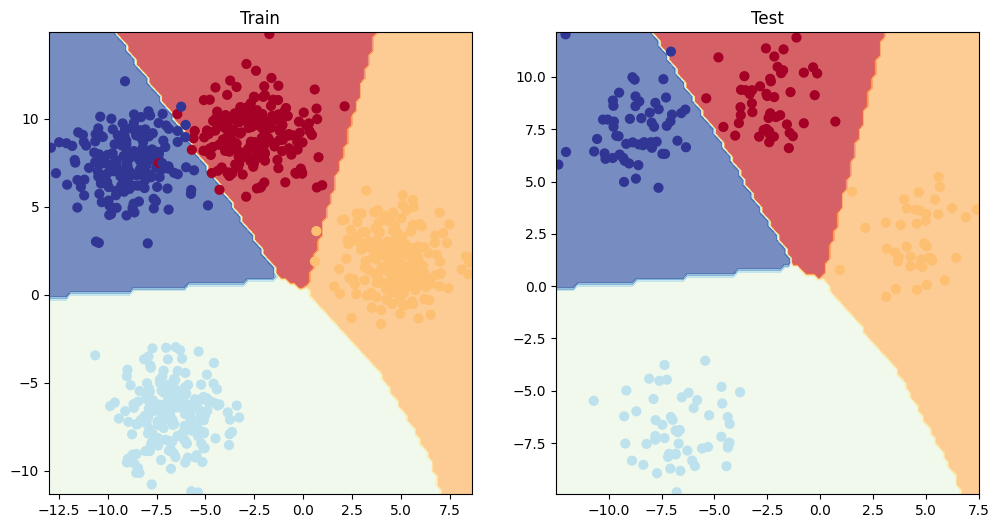

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4,X_blobs_train,y_blobs_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4,X_blobs_test,y_blobs_test)

## On était pas obligé de mette de la non-linéarité (ReLU) dans notre modèle

# Extra : Metrics for classification :

* Accuracy (not good for imbalanced dataset)
* Recall (Higher leads to less FN)
* Precision (Higher leads to less FP)
* F1-score (Combination of Recall & Precision)
* Confusion Matrix
* Classification report (Collection of above)


=> torchmetrics or sklearn

 # Extra : Replicating non-linear activation fonction

In [ ]:
A=torch.arange(-10,10,1,dtype=torch.float32)
A.dtype, A

(torch.float32,
 tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
           2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.]))

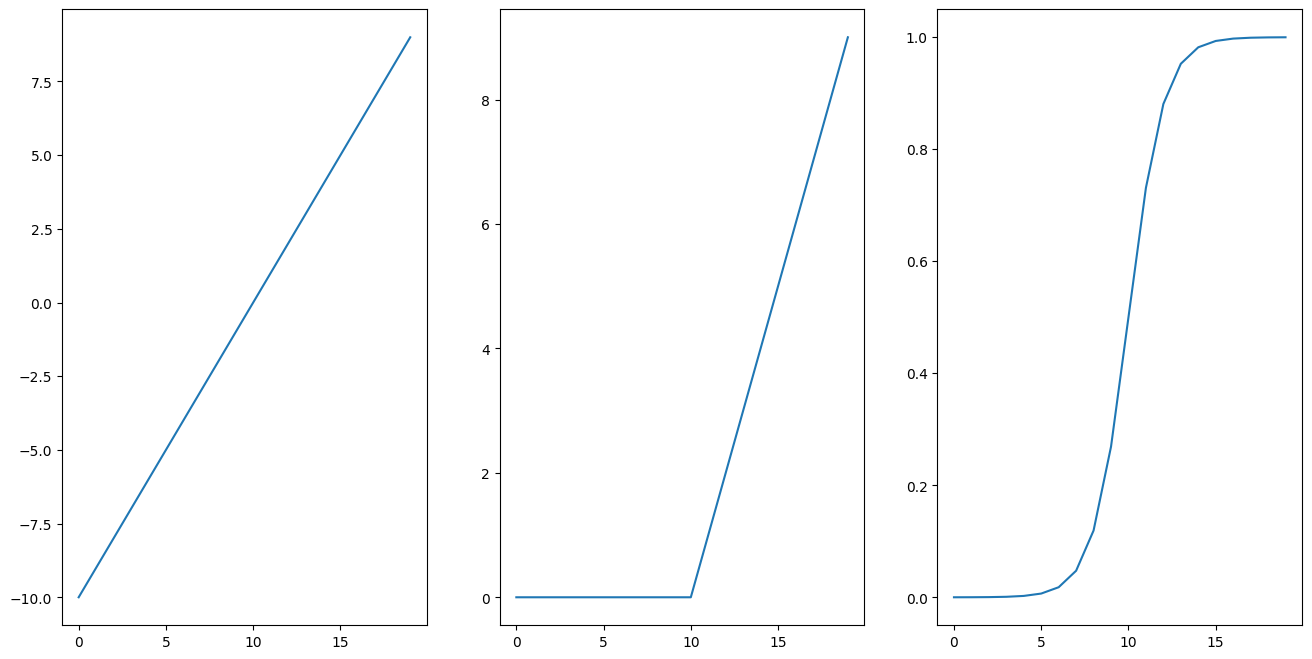

In [ ]:
plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
plt.plot(A)
plt.subplot(1,3,2)
plt.plot(torch.relu(A))
plt.subplot(1,3,3)
plt.plot(torch.sigmoid(A))

# Exercices !

https://www.learnpytorch.io/02_pytorch_classification/#exercises

In [2]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 5.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

torch.Size([800, 2]) torch.Size([200, 2]) torch.Size([800]) torch.Size([200])


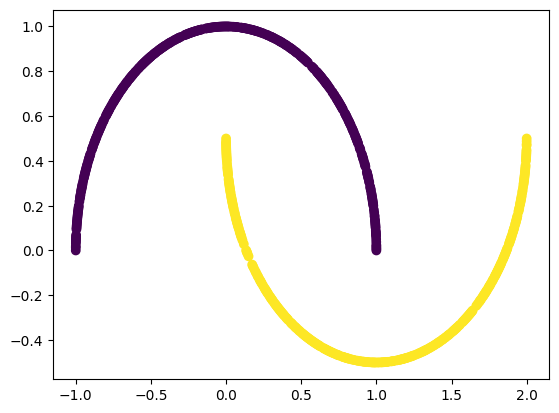

In [3]:
import sklearn
import sklearn.datasets
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torchmetrics

n_samples=1000

X,y=sklearn.datasets.make_moons(n_samples,random_state=42)

#Turn into tensor
X,y=torch.from_numpy(X).type(torch.float),torch.from_numpy(y).type(torch.float)

#Split :
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

#Visualize :
plt.scatter(X_train[:,0],X_train[:,1],c=y_train)

In [4]:
# Device agnostic code :

device="cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
# Build model :

class Model_Moons(nn.Module) :
  def __init__(self) :
    super().__init__()
    self.layer1=nn.Linear(in_features=2,out_features=8)
    self.layer2=nn.Linear(in_features=8,out_features=8)
    self.layer3=nn.Linear(in_features=8,out_features=1)
    self.layer4=nn.ReLU()
  def forward(self,x):
    return self.layer3(self.layer4(self.layer2(self.layer4(self.layer1(x)))))

model_0=Model_Moons().to(device)
model_0

Model_Moons(
  (layer1): Linear(in_features=2, out_features=8, bias=True)
  (layer2): Linear(in_features=8, out_features=8, bias=True)
  (layer3): Linear(in_features=8, out_features=1, bias=True)
  (layer4): ReLU()
)

In [6]:
# Loss & optimizer :
loss_fn = nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [7]:
# Training and testing loop :
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=1000

X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

metric=torchmetrics.classification.BinaryAccuracy().to(device)

for epoch in range(epochs):
  #Training
  model_0.train()
  y_logits=model_0(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))
  loss=loss_fn(y_logits,y_train)
  acc=100*metric(y_pred,y_train)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #Testing :
  model_0.eval()
  with torch.inference_mode() :
    test_log=model_0(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_log))
    test_loss=loss_fn(test_log,y_test)
    test_acc=100*metric(test_pred,y_test)
    if epoch%100==0 :
      print(f"Epoch :{epoch} | Loss : {loss:.4f} | Acc : {acc:.2f}% | Test loss : {test_loss:.2f}| Test acc :{test_acc:.2f}% ")


Epoch :0 | Loss : 0.6810 | Acc : 58.12% | Test loss : 0.68| Test acc :58.00% 
Epoch :100 | Loss : 0.3479 | Acc : 83.50% | Test loss : 0.37| Test acc :81.50% 
Epoch :200 | Loss : 0.2460 | Acc : 88.25% | Test loss : 0.25| Test acc :89.50% 
Epoch :300 | Loss : 0.2339 | Acc : 89.25% | Test loss : 0.23| Test acc :90.00% 
Epoch :400 | Loss : 0.2283 | Acc : 89.12% | Test loss : 0.23| Test acc :90.50% 
Epoch :500 | Loss : 0.2228 | Acc : 89.12% | Test loss : 0.22| Test acc :90.50% 
Epoch :600 | Loss : 0.2167 | Acc : 89.12% | Test loss : 0.21| Test acc :91.00% 
Epoch :700 | Loss : 0.2099 | Acc : 89.25% | Test loss : 0.20| Test acc :91.50% 
Epoch :800 | Loss : 0.2013 | Acc : 89.62% | Test loss : 0.19| Test acc :91.50% 
Epoch :900 | Loss : 0.1882 | Acc : 90.50% | Test loss : 0.18| Test acc :91.50% 


In [8]:
## On importe des fonctions d'aide depuis un repository GitHub

import requests
from pathlib import Path

if Path("helper_functions.py").is_file() :
  print("help_functions.py already exists, skipping dowload")
else :
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f :
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


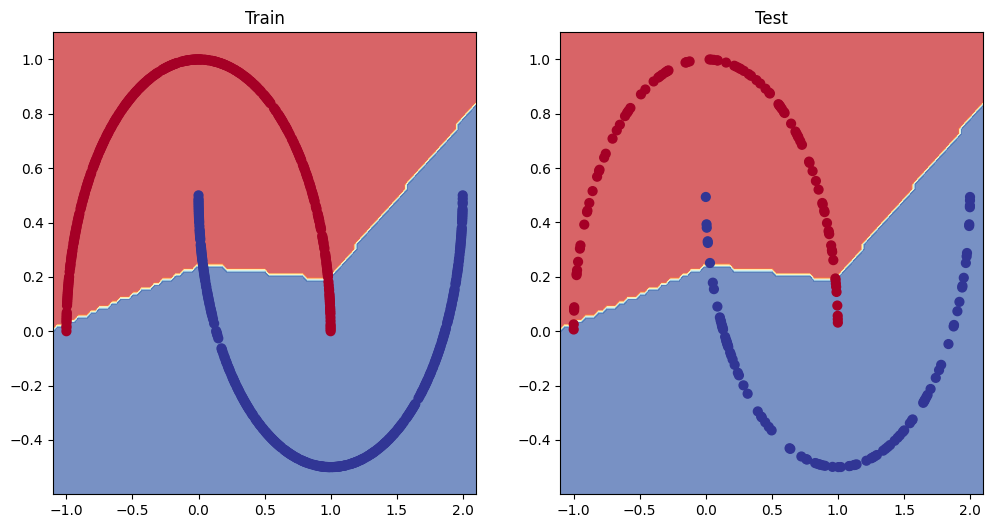

In [9]:
# Make pred and plot :
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

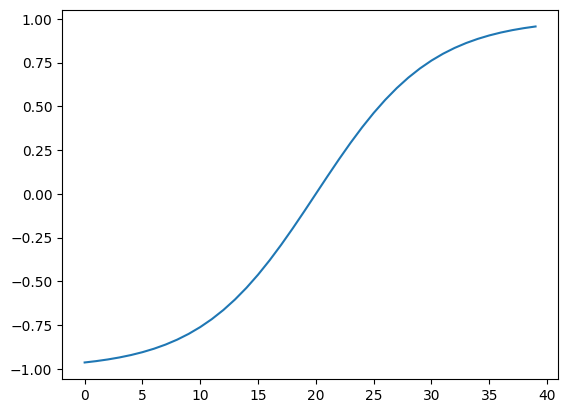

In [18]:
x=torch.arange(-2,2,step=0.1)
plt.plot(torch.tanh(x))

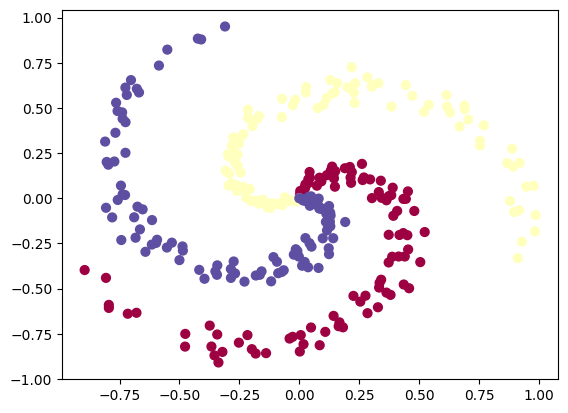

In [39]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [40]:
# Tensor
X,y=torch.from_numpy(X).type(torch.float),torch.from_numpy(y).type(torch.long)

#Split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

X_train.shape,X_test.shape

(torch.Size([240, 2]), torch.Size([60, 2]))

In [41]:
# Build model :
class Model_Spiral(nn.Module) :
  def __init__(self,input=2,output=4,hidden=16) :
    super().__init__()
    self.layer1=nn.Linear(in_features=input,out_features=hidden)
    self.layer2=nn.Linear(in_features=hidden,out_features=hidden)
    self.layer3=nn.Linear(in_features=hidden,out_features=output)
    self.relu=nn.ReLU()

  def forward(self,x) :
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model_1=Model_Spiral().to(device)
model_1

Model_Spiral(
  (layer1): Linear(in_features=2, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=4, bias=True)
  (relu): ReLU()
)

In [54]:
## Loss & optim
loss_fn = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_1.parameters(),lr=0.2)

In [55]:
# Loops :

epochs=500

X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)

metric=torchmetrics.Accuracy(task="multiclass", num_classes=4)

for epoch in range(epochs):
  model_1.train()
  y_logits=model_1(X_train)
  y_pred=torch.argmax(torch.softmax(y_logits,dim=1),dim=1)

  loss=loss_fn(y_logits,y_train)
  acc=100*metric(y_pred,y_train)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_log=model_1(X_test)
    test_pred=torch.argmax(torch.softmax(test_log,dim=1),dim=1)

    test_loss=loss_fn(test_log,y_test)
    test_acc=100*metric(test_pred,y_test)

    if epoch%20==0 :
      print(f"Epoch :{epoch} | Loss :{loss:.4f} | Acc : {acc:.2f}% | Test loss :{test_loss:.2f} | Test acc : {test_acc:.2f}%")


Epoch :0 | Loss :0.3908 | Acc : 77.92% | Test loss :0.29 | Test acc : 86.67%
Epoch :20 | Loss :0.4040 | Acc : 78.75% | Test loss :0.33 | Test acc : 85.00%
Epoch :40 | Loss :0.3744 | Acc : 79.58% | Test loss :0.32 | Test acc : 85.00%
Epoch :60 | Loss :0.3625 | Acc : 79.17% | Test loss :0.31 | Test acc : 86.67%
Epoch :80 | Loss :0.3559 | Acc : 80.00% | Test loss :0.30 | Test acc : 85.00%
Epoch :100 | Loss :0.3453 | Acc : 79.58% | Test loss :0.38 | Test acc : 85.00%
Epoch :120 | Loss :0.3361 | Acc : 80.00% | Test loss :0.26 | Test acc : 86.67%
Epoch :140 | Loss :0.3412 | Acc : 78.33% | Test loss :0.29 | Test acc : 81.67%
Epoch :160 | Loss :0.3318 | Acc : 79.17% | Test loss :0.24 | Test acc : 86.67%
Epoch :180 | Loss :0.3108 | Acc : 82.08% | Test loss :0.51 | Test acc : 86.67%
Epoch :200 | Loss :0.3312 | Acc : 80.00% | Test loss :0.66 | Test acc : 83.33%
Epoch :220 | Loss :0.2624 | Acc : 86.25% | Test loss :0.50 | Test acc : 90.00%
Epoch :240 | Loss :0.2950 | Acc : 87.50% | Test loss :1.04

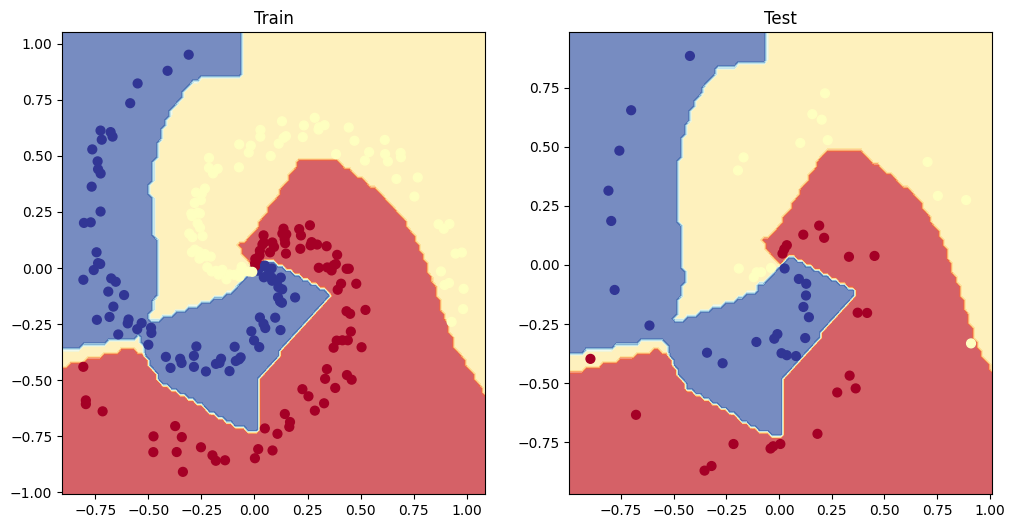

In [57]:
# Visualize :
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test,y_test)